## Table of Contents
* [Introduction](#Introduction)


* [1. Loading in our Data](#1.-Loading-in-our-Data)
* [2. EDA and Data Cleaning](#2.-EDA-and-Data-Cleaning)
* [3. Adding Image Paths to our Dataframe](#3.-Adding-Image-Paths-to-our-Dataframe)
* [4. Resizing our Images](#4.-Resizing-our-Images)
* [5. Modifying Our Model for Improvement](#5.-Modifying-Our-Model-for-Improvement)
* [6. Balancing Data for Binary Classification](#6.-Balancing-Data-for-Binary-Classification)
* [7. Balancing Data for Lesion Classification](#7.-Balancing-Data-for-Lesion-Classification)


* [Conclusions](#Conclusions)

# Introduction

In this notebook, we will first import the data which has been placed into our working directory by the previous notebook. Next, we will perform EDA on and clean our .csv file containing our metadata. Then, we will bring all of our image data into a single directory, resize it if nessassary, and partition and distribute it based upon our modeling needs. Throughout this notebook, it will be key to remember the importance of balanced classes for the creation of Convolutional Neural Networks, and to utilize our metadata to distribute our files in a way that will be productive for modeling.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import shutil
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
import cv2
# import keras
# come back to this whenever importing a new library

# 1. Loading in our Data

First, let us create an `actual_df` with the data taken from our metadata.csv file. This dataframe will contain information about our images which we can view and categorize our image data by.

In [2]:
actual_df = pd.read_csv("Daniel Logan Capstone Data/HAM10000_metadata.csv")
actual_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


Now that we have this dataset loaded in, let us hold off on EDA and cleaning it. First, let us figure out the best ways to load in our image data.

One of the first challenges of this dataset is that all of the images are not within the same directory, and the source documentation at our original [Harvard Datasource](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T) specifies that this was done for file size considerations. To resolve this, I consulted with [this page on geeksforgeeks](https://www.geeksforgeeks.org/how-to-merge-multiple-folders-into-one-folder-using-python/) to find a simple method to merge all of the files from both image directories into a single directory. In this single, large directory, we will conduct our data cleaning, and finally split this cleaned data into our training, testing, and validation datasets ready to be used for our modeling.

In [3]:
current_folder = os.getcwd()
folders = [os.path.join('Daniel Logan Capstone Data', x) for x 
           in ('HAM10000_images_part_1','HAM10000_images_part_2')]
folders

['Daniel Logan Capstone Data\\HAM10000_images_part_1',
 'Daniel Logan Capstone Data\\HAM10000_images_part_2']

With this, folders contains two folder paths which contain all of our images.

In [4]:
def make_new_folder(folder_name, parent_folder_path):
    path = os.path.join(parent_folder_path, folder_name)
    try:
        mode= 0o777
        os.mkdir(path, mode)
    except OSError as error:
        print(error)

Next, let us move all of the images from our two image directories into a new directory, our `image_directory`.

In [5]:
merge_folder = "image_directory"
# merge_folder path - current_folder

# Next, checking to see if there is anything present in the file location of the merge folder. If there
# is, we delete it.
if os.path.exists(merge_folder) and os.path.isdir(merge_folder):
    shutil.rmtree(merge_folder)

# + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)
    
make_new_folder(merge_folder, current_folder)

source_folders = folders

for i in range(len(source_folders)):
    path = os.path.join('', source_folders[i])
    src_files = os.listdir(path)
    for file_name in src_files:
        full_file_name = os.path.join(path,file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, merge_folder_path)
lst = os.listdir(merge_folder_path) # your directory path
number_files = len(lst)
print(number_files)

10015


Ordinarily, here I would perform a sanity check that all of our images are the same size. However, this step only needs to be taken if we end up not resizing our images. As the current size of our images are (450, 600), it seems likely that we will need to shrink the size of our data in order to create a CNN without too much computational expense for a high-end laptop.

Worthy of note is that the original dataset actually has more images than just the 10015 jpg files which are now stored in `merge_folder`, as the original challenge also included a seperate test and validation dataset. However, metadata on these two sets seem to no longer be publically available, so this means that these images, originally designated as just the training dataset will instead need to be split into a training set, a testing set, and a validation set for our modeling.

# 2. EDA and Data Cleaning

First, let us take another look at the head of our dataframe, `actual_df`.

In [6]:
actual_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


This image set has a wide variety of different types of lesions which are identified in our `dx` column, but not in a very human-readable way. Let us create a new column, `lesion_type`, which contains the information in the `dx` column in a more human-readable way. In order to accomplish this, we can create a dictionary of lesion types based on the documentation available at the [original Harvard challenge page](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T) which states that the lesions in the `dx` column are: "Actinic keratoses and intraepithelial carcinoma / Bowen's disease (`akiec`), basal cell carcinoma `bcc`, benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, `bkl`), dermatofibroma (`df`), melanoma (`mel`), melanocytic nevi (`nv`) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, `vasc`)."

Additionally, we can employ a similar method in order to create a variable column, `cancer_risk`, which will store 0 if the image has a very low risk of any form of cancer or 1 if the image has a higher risk of cancer, or even a near-certain risk of cancer.

In [7]:
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis-like Lesions',
    'bcc': 'Basal cell carcinoma',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [8]:
actual_df['lesion_type'] = actual_df['dx'].map(lesion_type_dict.get)

In [9]:
#check that these two have the same counts for each value
print(actual_df['lesion_type'].value_counts())
print(actual_df['dx'].value_counts())

Melanocytic Nevi                 6705
Melanoma                         1113
Benign Keratosis-like Lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: lesion_type, dtype: int64
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


Since this new column which we have created, `lesion_type`, is so much more human readable and contains all of the data present in the `dx` column, we can safely drop our original column.

One possible issue which will be dicussed throughout modeling is the great levels of imbalance in this data, which could result in our models learning to identify our overrepresented samples far more than our underrepresented samples. For now, though, we will leave these as is.

Now, preliminary research on each of these catagorical variables can shed some light on whether they belong for our new `cancer_risk` variable. In assigning these variables, I readily admit that I am not in any way a doctor, and any who are may have ideas for how these classifications can be improved. In assigning these categories, I have looked at the [Mayo Clinic website](https://www.mayoclinic.org), [National Library of Medicine Articles](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4078200/), [Harvard Health Articles](https://www.health.harvard.edu) and [PubMed Articles](https://pubmed.ncbi.nlm.nih.gov/).

In [10]:
cancer_risk_dict = {
    'Actinic keratoses': 1,
    # "Left untreated, the risk of actinic keratoses turning into a type of 
    #  skin cancer called squamous cell carcinoma is about 5% to 10%."
    'Melanocytic Nevi': 1,
    # "Congenital melanocytic naevi (CMN) are a known risk factor for melanoma, 
    # with the greatest risk currently thought to be in childhood."
    'Melanoma': 1,
    # Melanoma is known to be the most serious and deadly type of skin cancer. For this reason,
    # it should very obviously be considered high risk and cancerous.
    'Benign Keratosis-like Lesions': 0,
    # Seborrheic keratoses are harmless and not contagious. They don't need treatment, but you
    # may decide to have them removed if they become irritated by clothing or you don't 
    # like how they look.
    'Basal cell carcinoma': 1,
    # Basal cell carcinoma is a type of skin cancer. Basal cell carcinoma begins in the basal
    # cells — a type of cell within the skin that produces new skin cells as old ones die off.
    'Vascular lesions': 1,
    # Life-threatening complications associated with IHs, such as tissue destruction, 
    # distortion, and obstruction, has been estimated to be around 10%. Its phase,
    # size, and location are usually good predictors of future complications.
    'Dermatofibroma': 0
    # Dermatofibromas are small, noncancerous (benign) skin growths that can develop anywhere
    # on the body but most often appear on the lower legs, upper arms or upper back. 
}

Sources for the above designations are available at:

1. [Actinic keratoses](https://www.mayoclinic.org/diseases-conditions/actinic-keratosis/symptoms-causes/syc-20354969)
2. [Melanocytic Nevi](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5484991/)
3. [Melanoma](https://www.mayoclinic.org/diseases-conditions/melanoma/symptoms-causes/syc-20374884)
4. [Benign Keratosis-like Lesions](https://www.mayoclinic.org/diseases-conditions/melanoma/symptoms-causes/syc-20374884)
5. [Basal cell carcinoma](https://www.mayoclinic.org/diseases-conditions/basal-cell-carcinoma/symptoms-causes/syc-20354187)
6. [Vascular lesions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4078200/)
7. [Dermatofibroma](https://www.health.harvard.edu/a_to_z/dermatofibroma-a-to-z)

In [11]:
# Now, we can create our binary "cancer_risk" column
actual_df['cancer_risk'] = actual_df['lesion_type'].map(cancer_risk_dict.get)

In [12]:
actual_df['cancer_risk'].value_counts()

1    8801
0    1214
Name: cancer_risk, dtype: int64

As we can see, our new binary column, like with our categorical columns, is skewed fairly heavily. However, unlike with the categorical columns, this may prove to be less of an issue, as a training dataset which is skewed with images of higher risk is likely to be subject to more Type I error and less Type II error, which may be preferable given how much more dangerous a false negative diagnosis is than a false positive diagnosis.

In [13]:
actual_df = actual_df.drop('dx',axis=1)
actual_df.head()

,lesion_id,image_id,dx_type,age,sex,localization,lesion_type,cancer_risk
0,HAM_0000118,ISIC_0027419,histo,80.0,male,scalp,Benign Keratosis-like Lesions,0
1,HAM_0000118,ISIC_0025030,histo,80.0,male,scalp,Benign Keratosis-like Lesions,0
2,HAM_0002730,ISIC_0026769,histo,80.0,male,scalp,Benign Keratosis-like Lesions,0
3,HAM_0002730,ISIC_0025661,histo,80.0,male,scalp,Benign Keratosis-like Lesions,0
4,HAM_0001466,ISIC_0031633,histo,75.0,male,ear,Benign Keratosis-like Lesions,0


Next, one thing worth considering about our dataset is that, while there are ~10,000 images, many images are of the same lesion as other images in our dataset. Let us find out how many images there are for lesions with the most pictures taken of them.

In [14]:
actual_df.lesion_id.value_counts()[range(0,100)]

HAM_0003789    6
HAM_0000835    6
HAM_0005263    6
HAM_0001863    6
HAM_0007427    5
              ..
HAM_0005481    3
HAM_0007552    3
HAM_0006980    3
HAM_0001218    3
HAM_0000747    3
Name: lesion_id, Length: 100, dtype: int64

It appears that there are no more than 6 pictures taken of the same lesion throughout our dataset. This could be important to consider, especially for classes of lesions which already have few images, as these few images could have even fewer original lesions.

To start with, let's look in our imported DataFrame to see whether there are any NaN values, and where these NaN values might be.

In [15]:
actual_df.isna().sum()

lesion_id        0
image_id         0
dx_type          0
age             57
sex              0
localization     0
lesion_type      0
cancer_risk      0
dtype: int64

It seems that there are 57 rows in the age column with NaN values. what percentage of rows are NaN values?

In [16]:
actual_df['age'].isna().value_counts(normalize=True)

# ~99.5% of the column seems to be

False    0.994309
True     0.005691
Name: age, dtype: float64

It looks like the 'age' column has 57 values which are NaN, which is . Let's look at these rows.

In [17]:
actual_df[actual_df['age'].isna()]

,lesion_id,image_id,dx_type,age,sex,localization,lesion_type,cancer_risk
968,HAM_0001186,ISIC_0033391,consensus,NaN,unknown,unknown,Benign Keratosis-like Lesions,0
969,HAM_0002660,ISIC_0033750,consensus,NaN,unknown,unknown,Benign Keratosis-like Lesions,0
970,HAM_0000372,ISIC_0033685,consensus,NaN,unknown,unknown,Benign Keratosis-like Lesions,0
971,HAM_0000948,ISIC_0033631,consensus,NaN,unknown,unknown,Benign Keratosis-like Lesions,0
972,HAM_0000983,ISIC_0033490,consensus,NaN,unknown,unknown,Benign Keratosis-like Lesions,0
973,HAM_0007281,ISIC_0034283,consensus,NaN,unknown,unknown,Benign Keratosis-like Lesions,0
974,HAM_0001561,ISIC_0032740,consensus,NaN,unknown,unknown,Benign Keratosis-like Lesions,0
975,HAM_0000825,ISIC_0034186,consensus,NaN,unknown,unknown,Benign Keratosis-like Lesions,0
977,HAM_0006074,ISIC_0034252,consensus,NaN,unknown,unknown,Benign Keratosis-like Lesions,0
978,HAM_0006074,ISIC_0033829,consensus,NaN,unknown,unknown,Benign Keratosis-like Lesions,0


Since there are so few values with NaN compared to the overall percentage of data, we can fill these NaN values with the average for now. However, viewing this NaN dataframe also showed that there are a number of other unusual values in the dataframe (such as 'unknown') which should also be looked into column by column.

In [18]:
#Our best next step is to fill our NaN values with the mean age
actual_df['age'] = actual_df['age'].fillna(value=actual_df['age'].mean())

In [19]:
# checking our work
actual_df.isna().sum()

lesion_id       0
image_id        0
dx_type         0
age             0
sex             0
localization    0
lesion_type     0
cancer_risk     0
dtype: int64

Now that we have filled values which are NaN, though, we should continue to check our data to see whether or not this data is clean. We can do this column by column by visualizing the number of occurances of distinct values, expecially values which imply that our data is not robust, like 'Unknown'. We should only look at the visualizations besides lesion_id and image_id, though, as these will have far too many distinct values to effectively visualize.

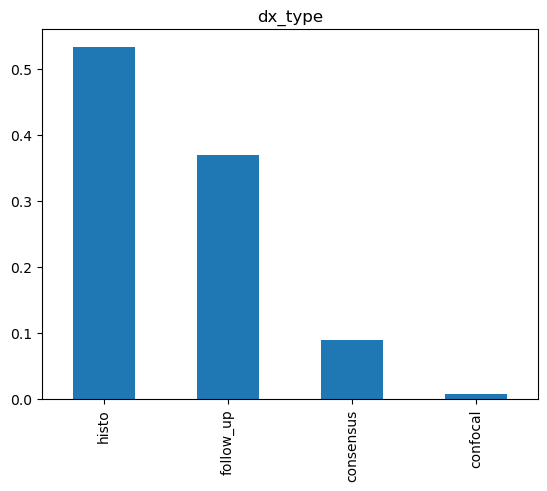

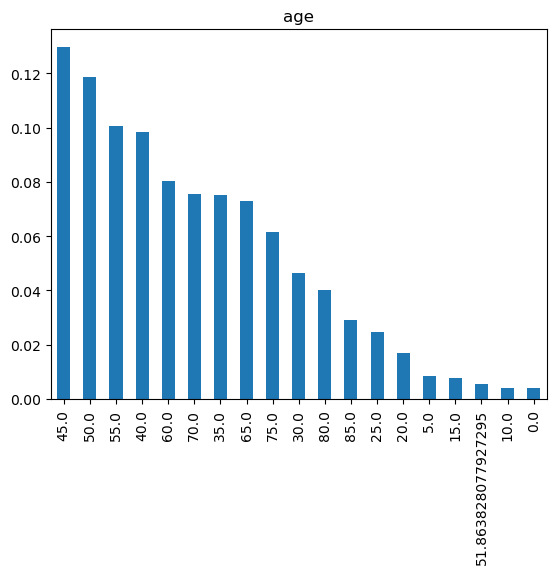

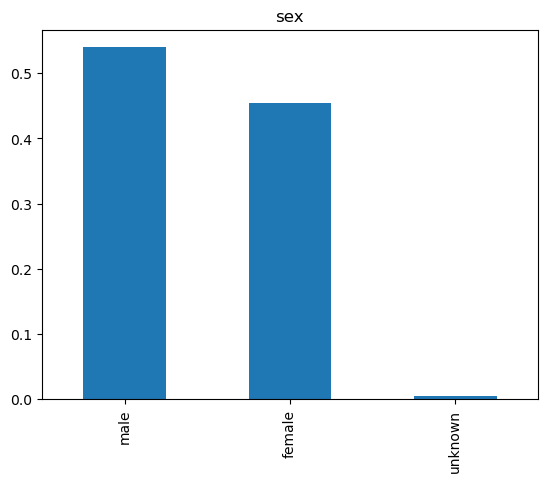

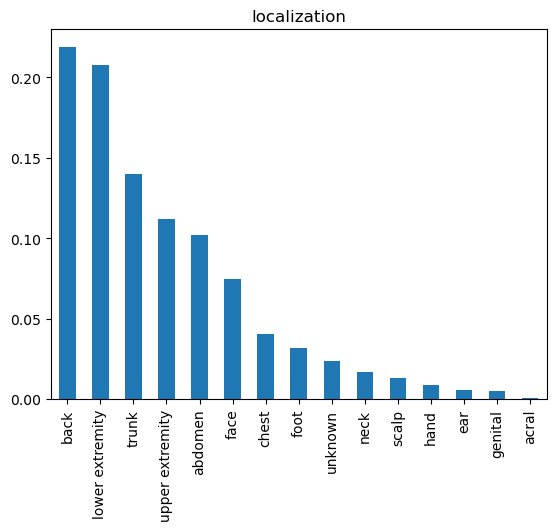

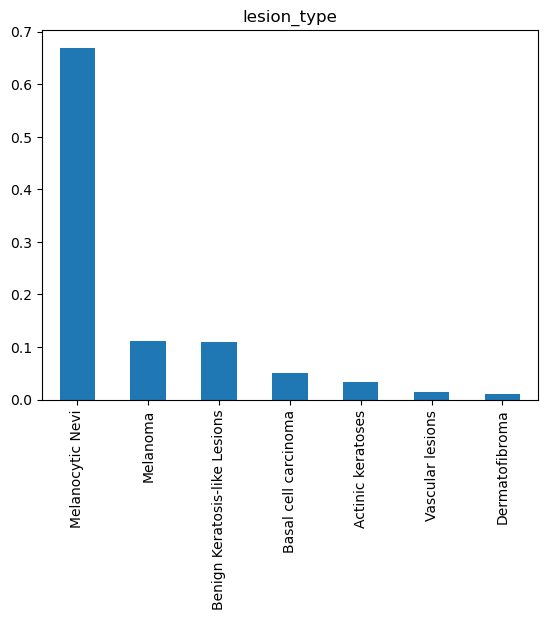

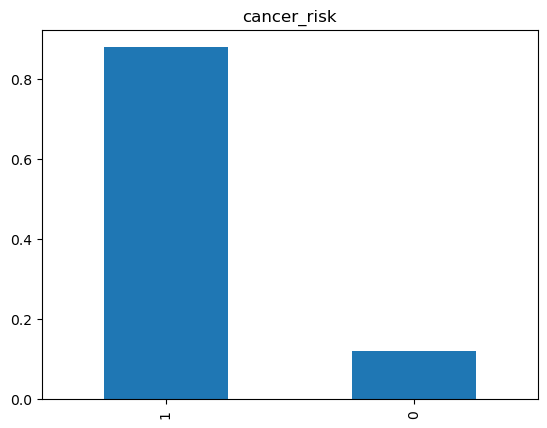

In [20]:
for i in actual_df.columns[2:]: #starting from column index 2 to exclude our image_id and lesion_id
    plt.figure()
    actual_df[i].value_counts(normalize=True).plot(kind='bar')
    plt.title(i)
    plt.show()

It seems that, while there are some values where the patient's sex is unknown, the rest of the data appears to be fairly clean. Let us see an exact percentage of the 'sex' column which is populated with this unknown value.

In [21]:
actual_df['sex'].value_counts(normalize=True)

male       0.539790
female     0.454518
unknown    0.005691
Name: sex, dtype: float64

'Unknown' seems to make up ~0.56% of the sex column. In this case, this seems to be a small enough portion of the data that it does not make the coloumn unusable, though it will be good to keep this in mind . Additionally, since this is a categorical column instead of a numerical one, there is likely no need to substitute these values, and instead can proceed with these values still in our dataset.

# 3. Adding Image Paths to our Dataframe

For our next step, we will need to create a new column which holds the file path for each individual image. Fortunately, our `image_id` column already contains an object which has much of this information, meaning that we can create these filepaths using an f-string starting with the value in `image_id` as a base.

In [22]:
actual_df['image_id']

0        ISIC_0027419
1        ISIC_0025030
2        ISIC_0026769
3        ISIC_0025661
4        ISIC_0031633
             ...     
10010    ISIC_0033084
10011    ISIC_0033550
10012    ISIC_0033536
10013    ISIC_0032854
10014    ISIC_0032258
Name: image_id, Length: 10015, dtype: object

Since the default state of the data when it is downloaded has imagages in two seperate directories, I first moved these images into a single directory on windows simply by dragging and dropping.

In [23]:
image_id_ordered_list = list(actual_df['image_id'])

In [24]:
actual_df['image_path'] = ''
#this creates a new column full of empty strings which can be overwritten using the recursion below.

In [25]:
#now that our image id series has been converted into a list, we can create paths to our images and put them
#into our actual_df['path'] column.
for i in range(0,len(image_id_ordered_list)):
    actual_df['image_path'][i] = 'image_directory\\'+image_id_ordered_list[i]+'.jpg'

C:\Users\danie\AppData\Local\Temp\ipykernel_18216\3106135553.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_df['image_path'][i] = 'image_directory\\'+image_id_ordered_list[i]+'.jpg'


In [26]:
# To check our work, 
actual_df[['image_path','image_id']]
#These columns and rows seem to line up nicely with one another! Proceeding.

,image_path,image_id
0,image_directory\ISIC_0027419.jpg,ISIC_0027419
1,image_directory\ISIC_0025030.jpg,ISIC_0025030
2,image_directory\ISIC_0026769.jpg,ISIC_0026769
3,image_directory\ISIC_0025661.jpg,ISIC_0025661
4,image_directory\ISIC_0031633.jpg,ISIC_0031633
...,...,...
10010,image_directory\ISIC_0033084.jpg,ISIC_0033084
10011,image_directory\ISIC_0033550.jpg,ISIC_0033550
10012,image_directory\ISIC_0033536.jpg,ISIC_0033536
10013,image_directory\ISIC_0032854.jpg,ISIC_0032854


First of all, let us attempt to import a single image of data into jupyter notebook and show the resulting display.

In [27]:
image_1_path = 'image_directory\\ISIC_0027419.jpg'

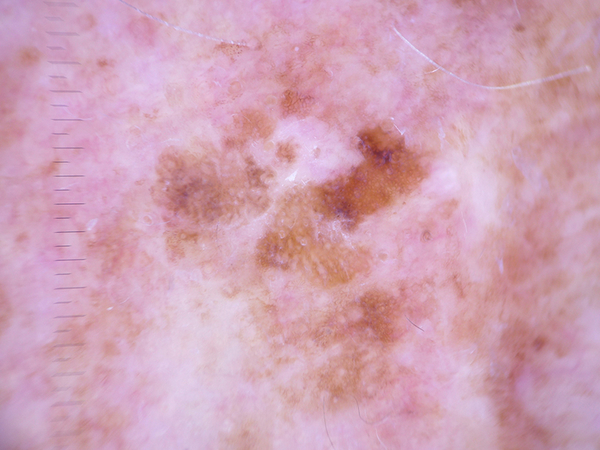

In [28]:
display(Image(filename=image_1_path))

In [29]:
#Checking to see if the file path column which we created worked correctly
same_image_path = actual_df['image_path'][0]

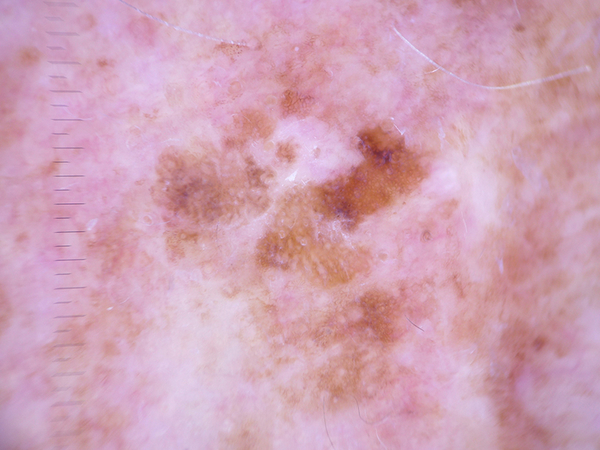

In [30]:
display(Image(filename=same_image_path))

In [31]:
img = cv2.imread(same_image_path)
print(f"Original Dimensions : {img.shape}")

Original Dimensions : (450, 600, 3)


This looks like we are returning the same image, meaning that our creation of the column `actual_df['path']` was a success!

Now, we have a cleaned dataframe which has all of the metadata which we will need for modeling, as well as a single directory which contains all of the images which we will need to train our models. Next, it is time to split up our dataframe into a training dataset, a testing dataset, and a validation dataset. Then, finally, we will need to move our images out of our temporary directory, `merge_folder`, and into `train_images`, `test_images`, and `validation_images`.

In [32]:
actual_df.to_csv('cleaned_skin_df.csv', index=False)

# 4. Resizing our Images

Now that we have our `image_path` column established, we can also use it to make modifications to images imputted to our merge folder. Making modifications to the files themselves before they are split into different sets, and before they are loaded into an `ImageDataGenerator` for our modeling, could come with the added benefit of increasing the speed of our models significantly, as images with smaller dimensions (including if we choose to move from RGB to greyscale) will significantly speed up modeling time.

For resizing images using cv2, I used [this page on imagekit](https://imagekit.io/blog/image-resizing-in-python/).

One very important thing to note about the cv2 library is that it does not, by default, work very well with RGB images. As seen below, while IPython opens an RGB image without issue, cv2 opens an RGB image as a BGR image. In order to avoid this as a potential issue of converting some of our images, particularly in our training

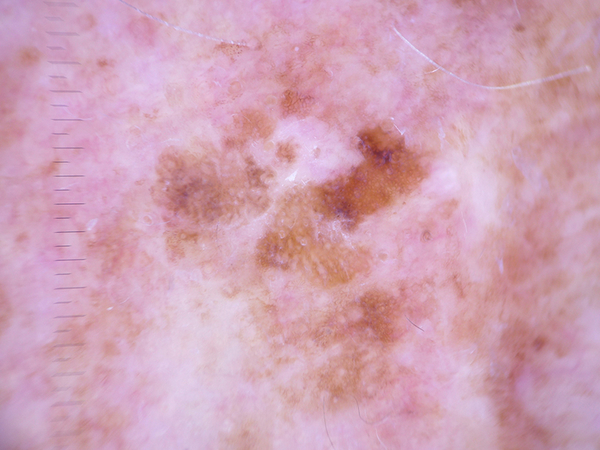

In [33]:
display(Image(actual_df['image_path'][0]))

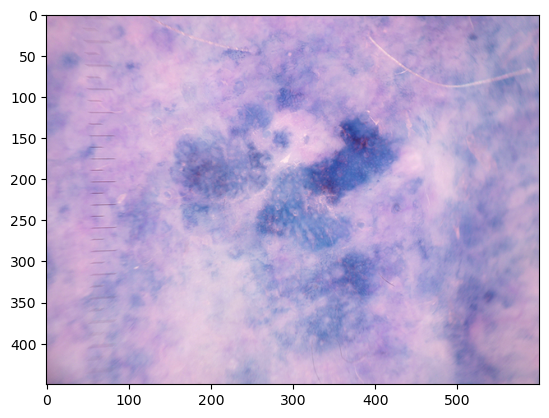

In [34]:
image = cv2.imread(actual_df['image_path'][0])
plt.imshow(image)

As the above images demonstrate, and as I have relearned many, many times throughout this project, cv2 does not work very well with RGB images unless one remains vigilant in converting the color back to RGB whenever the opportunity presents itself. Particularly important is when using `cv2.imwrite`, as cv2 seems to write even RGB images as BGR images on occasion.

In [35]:
for file in actual_df['image_path']:
    img = cv2.imread(file)
    # resize image by specifying custom width and height
    resized = cv2.resize(img, (100, 75))
    return_ = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    cv2.imwrite(file, cv2.cvtColor(return_, cv2.COLOR_BGR2RGB))

# 5. Splitting our Data

Next, it is time to make decisions about how our data will be split.

For our splits, I have chosen the following:

-70% training

-15% validation

-15% testing

These splits were chosen because, when working with images, having as many as possible in the testing dataset allows for more confidence that the model is learning from a sufficient number of datapoints. If results indicate that the models are overfitting, this split can be revisited and revised.

Now, we should split our data into these sets and organize our images into a train and validation set and a test set. For our training and validation set splits, we will be able to make these partitions while loading our data into keras/tensorflow. If we encounter difficulties with this, though, we will be able to revist the partition here.

In [36]:
df_train, df_test = train_test_split(actual_df, test_size=0.15, random_state=1)

Note that, because our later data generator will have a variable for taking a validation split for our data, there is not need to take a validation split here. For now, `df_train` contains both our training data and our validation data.

Next, let us check to ensure that these new splits appear to represent the overall dataset well.

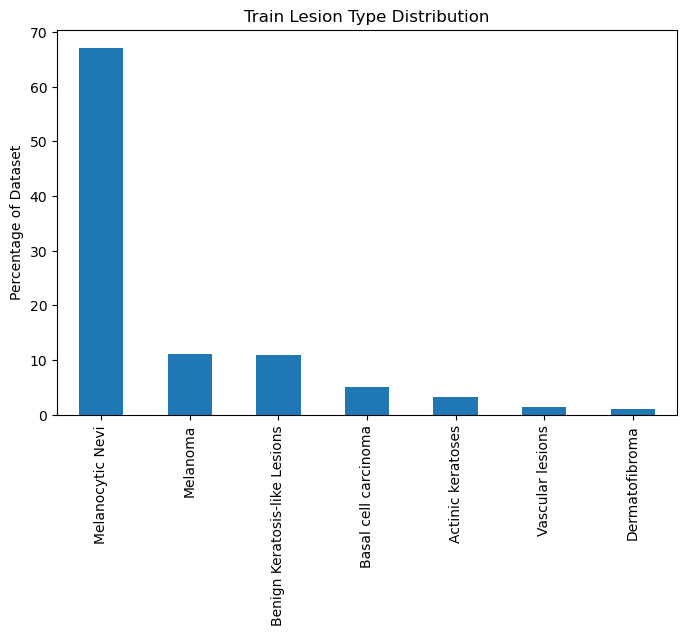

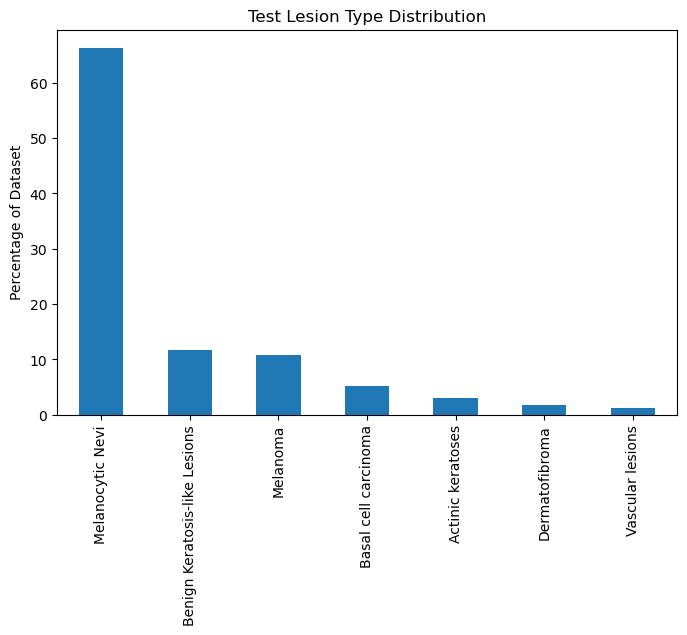

In [37]:
plt.figure(figsize=(8,5))
(df_train['lesion_type'].value_counts(normalize=True)*100).plot(kind='bar')
plt.title('Train Lesion Type Distribution')
plt.ylabel('Percentage of Dataset')
plt.show()

plt.figure(figsize=(8,5))
(df_test['lesion_type'].value_counts(normalize=True)*100).plot(kind='bar')
plt.title('Test Lesion Type Distribution')
plt.ylabel('Percentage of Dataset')
plt.show()

While there still may be issues from imbalanced data in the future, for now, these train, test, and validation datasets seem to have split in such a way as to ensure that approximately the same ratio of each `lesion_type` are within our training/validation set and our testing set.

# 6. Balancing Data for Binary Classification

In order to resolve these significant issues of class imbalance, our best strategies will involve creating image samples where the underrepresented classes are modified (and as nessassarily, duplicated) until their image folders contain the same number of inputs as the dominant class. Due to this duplication, we will need to remain vigilant about the possibility of overfitting for our undersampled classes, but this this may be prefereable to removing data from the dominant class, as this would result in our models missing valid, clean input data. If overfitting proves a significant issue in our modeling, this step may be revisited.

One tool at our disposal, the `cv2` library, has a number of ways to manipulate images. For our purposes, one manipulation which is particularly useful is the `flip` function, which allows for the flipping of images along the horizontal axis, vertical axis, or both. This is practical for our models because, since we are dealing with images of skin lesions, there is no nessassary orientation which must be maintained for identification. Theoretically, these images could have been taken from any viewing angle of the lesion. For this reason, using horizontal and vertical flippings of the images will allow us to create new inputs for these underrepresented classes.

In [38]:
same_image_path

'image_directory\\ISIC_0027419.jpg'

Original Dimensions : (75, 100, 3)


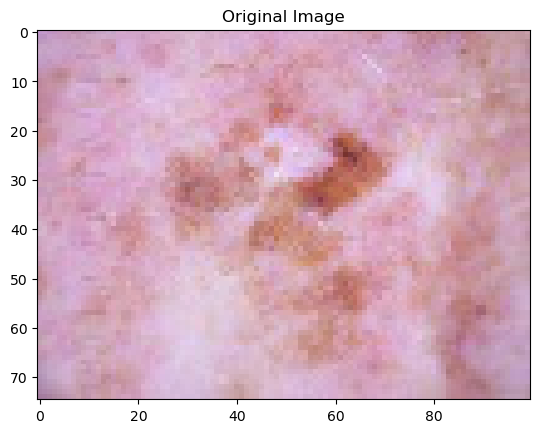

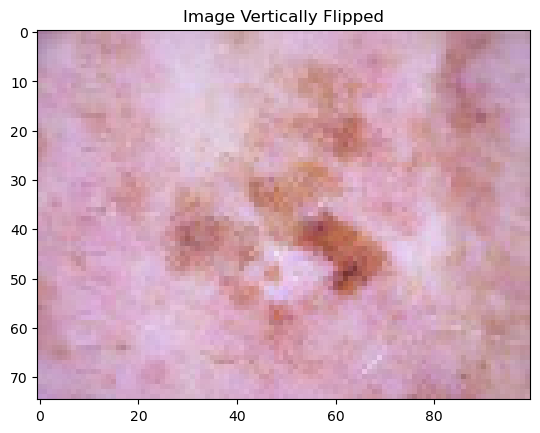

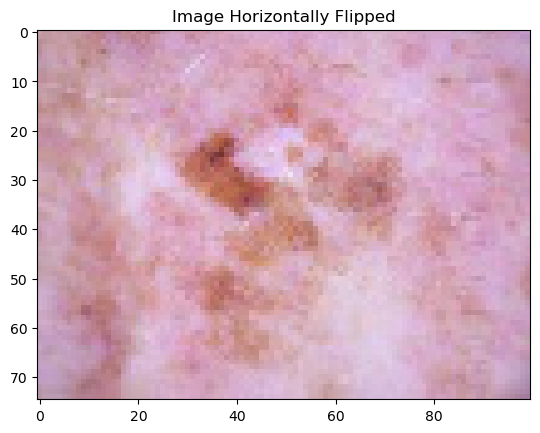

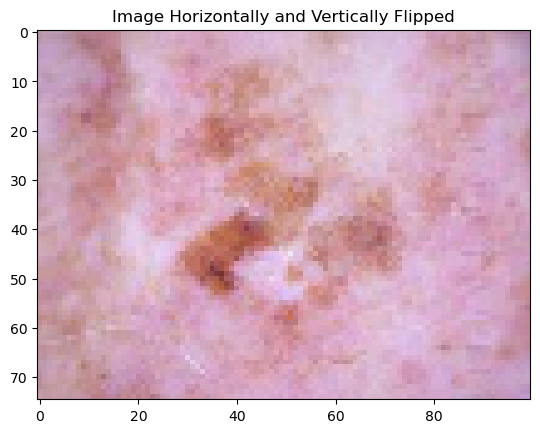

In [39]:
load = cv2.imread(same_image_path)
img = cv2.cvtColor(load, cv2.COLOR_BGR2RGB) # This is a nessassary step, as cv2 reads images by default
# as BGR images which can sometimes color reds as blues and vice versa.
print(f"Original Dimensions : {img.shape}")
img_vert_flip = cv2.flip(img, 0) # in cv2.flip, the input 0 means that there will be a vertical flip
img_hori_flip = cv2.flip(img, 1) # in cv2.flip, the input 1 means that there will be a horizontal flip
img_both_flip = cv2.flip(img, -1) # in cv2.flip, the input -1 means that there will be a horizontal
# flip and a vertical flip
plt.imshow(img)
plt.title("Original Image")
plt.show()
plt.imshow(img_vert_flip)
plt.title("Image Vertically Flipped")
plt.show()
plt.imshow(img_hori_flip)
plt.title("Image Horizontally Flipped")
plt.show()
plt.imshow(img_both_flip)
plt.title("Image Horizontally and Vertically Flipped")
plt.show()

As can be seen with all 4 images above, any flipping which might occur to the image does not change the fact that the image is one of a skin lesion. Unlike a classification task with a correct orrientation (for example, MNIST digits), this classification task does not require that images are viewed through a particular viewing angle.

Utilizing these strategies, we will be able to create input data for our underrepresented classes which will teach our model not to overfit on our overrepresented classes.

We can save our training/validation .csv and our testing .csv for future reference should we need
them again at some point of this notebook or in a future notebook.

In [40]:
df_train.to_csv('train_skin_df.csv', index=False)
df_test.to_csv('test_skin_df.csv', index=False)

Next, we should create folders for our images which will contain which images belong to the training set, which belong to the validation set, and which belong to the testing set. To inform how to structure these folders, I considered these scripts available at [studymachinelearning](https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/)

In [41]:
if os.path.exists('skin_train') and os.path.isdir('skin_train'):
    shutil.rmtree('skin_train')
make_new_folder('skin_train', '')
if os.path.exists('skin_test') and os.path.isdir('skin_test'):
    shutil.rmtree('skin_test')
make_new_folder('skin_test', '')

In [42]:
make_new_folder('cancer_risk', 'skin_train')

Let us start with the creation of our directory for our dominant class. This will allow us to inform the approximate number of image files which should be, through various methods, represented for our non-dominant classes, as well.

In [43]:
source_folder = 'image_directory'
merge_folder_path = 'skin_train/cancer_risk'
if os.path.exists(merge_folder_path) and os.path.isdir(merge_folder_path):
    shutil.rmtree(merge_folder_path)
make_new_folder('cancer_risk', 'skin_train')
path = os.path.join('')
dominant_src_files = df_train['image_path'][df_train['cancer_risk']==1]
for file_name in dominant_src_files:
    full_file_name = os.path.join(path,file_name)
    shutil.copy(full_file_name, merge_folder_path)
dominant_src_count = len(dominant_src_files)
dominant_src_count

7499

Now that we have our folder for our dominant class, let us create a similar folder for our non-dominant class and see how big the discrpency is between the two.

In [44]:
source_folder = 'image_directory'
merge_folder_path = 'skin_train/low_cancer_risk'
if os.path.exists(merge_folder_path) and os.path.isdir(merge_folder_path):
    shutil.rmtree(merge_folder_path)
make_new_folder('low_cancer_risk', 'skin_train')
path = os.path.join('')
src_files = df_train['image_path'][df_train['cancer_risk']==0]
for file_name in src_files:
    full_file_name = os.path.join(path,file_name)
    shutil.copy(full_file_name, merge_folder_path)
print(len(src_files))

1013


Our non-dominant class images have also been successfully transfered into our folder. However, this is just the first step, as we now must ensure that our non-dominant class has a similar number of images to consider by our generator that our dominant class has.

In [45]:
source_folder = 'skin_train/low_cancer_risk'
merge_folder_path = 'skin_train/low_cancer_risk'
path = os.path.join('')
src_files = [source_folder] * len(os.listdir(source_folder))
src_files = glob(f'./{source_folder}/*.jpg')
for file_name in src_files:
    load = cv2.imread(file_name)
    img = cv2.cvtColor(load, cv2.COLOR_BGR2RGB) # This is a nessassary step, as cv2 reads 
    # images by default as BGR images which can sometimes color reds as blues and vice versa.
    file_name = file_name[0:-4] # this is done so that we are able to insert into our string prior
    # to the .jpg portion of our files, as this can be added back after our new strings
    horiz_file_name = file_name + '_horiz.jpg'
    img_hori_flip = cv2.flip(img, 1)
    img_hori_return = cv2.cvtColor(img_hori_flip, cv2.COLOR_BGR2RGB)
    cv2.imwrite(horiz_file_name, img_hori_return) #this will create an image fliped over our horizontal
    # axis (y-axis)
    vert_file_name = file_name + '_vert.jpg'
    img_vert_flip = cv2.flip(img, 0)
    img_vert_return = cv2.cvtColor(img_vert_flip, cv2.COLOR_BGR2RGB)
    cv2.imwrite(vert_file_name, img_vert_return) # This will create an image flipped over our vertical
    # axis (x-axis)
    img_horiz_vert_flip = cv2.flip(img, -1)
    img_horiz_vert_return = cv2.cvtColor(img_vert_flip, cv2.COLOR_BGR2RGB)
    horiz_vert_file_name = file_name + '_horiz_vert.jpg'
    cv2.imwrite(horiz_vert_file_name, img_horiz_vert_return) # this will create an image which is
    #fliped over both axes. This could also be interpreted as being an image which has been
    # rotated 180 degrees

In [46]:
source_folder = 'skin_train/low_cancer_risk'
non_dominant_src_count = len(os.listdir(source_folder))
non_dominant_src_count

4052

Now, our non-dominant image directory has 4052. As this is 4 times as many images as this directory started out with, making this a significant improvement to our class imbalance issue. Still, class imbalance may prove to be an issue if the directory is left like so. Our final method for oversampling our non-dominant class is to create copies of our images in our non-dominant class until the classes are well balanced. 

In [47]:
files_to_clone = dominant_src_count - non_dominant_src_count
files_to_clone

3447

In [48]:
path = 'skin_train/low_cancer_risk'
all_files = glob(f'./{path}/*.jpg')
copied_file_index = np.random.choice(len(all_files), size=files_to_clone, replace=False) # replace=False
# ensures that the same image won't be copied twice
for i in copied_file_index:
    copy_name = all_files[i][0:-4]  + '_copy.jpg'
    shutil.copy(all_files[i], copy_name)

In [49]:
path = 'skin_train/low_cancer_risk'
len(glob(f'./{path}/*.jpg'))

7499

In [50]:
if os.path.exists('skin_test') and os.path.isdir('skin_test'):
    shutil.rmtree('skin_test')

In [51]:
make_new_folder('skin_test', '')

In [52]:
source_folder = 'image_directory'
merge_folder_path = 'skin_test/low_cancer_risk'
if os.path.exists(merge_folder_path) and os.path.isdir(merge_folder_path):
    shutil.rmtree(merge_folder_path)
make_new_folder('low_cancer_risk', 'skin_test')
path = os.path.join('')
src_files = df_test['image_path'][df_test['cancer_risk']==0]
for file_name in src_files:
    full_file_name = os.path.join(path,file_name)
    shutil.copy(full_file_name, merge_folder_path)

In [53]:
len(os.listdir(merge_folder_path))

201

In [54]:
source_folder = 'image_directory'
merge_folder_path = 'skin_test/cancer_risk'
if os.path.exists(merge_folder_path) and os.path.isdir(merge_folder_path):
    shutil.rmtree(merge_folder_path)
make_new_folder('cancer_risk', 'skin_test')
path = os.path.join('')
src_files = df_test['image_path'][df_test['cancer_risk']==1]
for file_name in src_files:
    full_file_name = os.path.join(path,file_name)
    shutil.copy(full_file_name, merge_folder_path)

In [55]:
len(os.listdir(merge_folder_path))

1302

# 7. Balancing Data for Lesion Classification

Prior to performing transformations to our images, as seen above, we should first check and see whether our three least represented categories of images have greater than 100 unique lesions which have been studied. For any lesion types which have fewer than 100 lesions which the data is based on, this is not enough data to consider for deep learning. Even if we are able to build a model which can acurately predict upon the data in our validation and test sets, we still would not be able to have much confidence in our model's generalizability for new images if it was based on so few lesions.

In [56]:
actual_df['lesion_type'].value_counts()

Melanocytic Nevi                 6705
Melanoma                         1113
Benign Keratosis-like Lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: lesion_type, dtype: int64

In [57]:
act_df = actual_df[actual_df['lesion_type']=='Actinic keratoses']
act_df

,lesion_id,image_id,dx_type,age,sex,localization,lesion_type,cancer_risk,image_path
9687,HAM_0002644,ISIC_0029417,histo,80.0,female,neck,Actinic keratoses,1,image_directory\ISIC_0029417.jpg
9688,HAM_0006002,ISIC_0029915,histo,50.0,female,face,Actinic keratoses,1,image_directory\ISIC_0029915.jpg
9689,HAM_0000549,ISIC_0029360,histo,70.0,male,upper extremity,Actinic keratoses,1,image_directory\ISIC_0029360.jpg
9690,HAM_0000549,ISIC_0026152,histo,70.0,male,upper extremity,Actinic keratoses,1,image_directory\ISIC_0026152.jpg
9691,HAM_0000673,ISIC_0029659,histo,70.0,female,face,Actinic keratoses,1,image_directory\ISIC_0029659.jpg
...,...,...,...,...,...,...,...,...,...
10009,HAM_0005705,ISIC_0031430,histo,75.0,female,lower extremity,Actinic keratoses,1,image_directory\ISIC_0031430.jpg
10010,HAM_0002867,ISIC_0033084,histo,40.0,male,abdomen,Actinic keratoses,1,image_directory\ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,histo,40.0,male,abdomen,Actinic keratoses,1,image_directory\ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,histo,40.0,male,abdomen,Actinic keratoses,1,image_directory\ISIC_0033536.jpg


In [58]:
len(act_df['lesion_id'].unique())

228

In [59]:
vascular_df = actual_df[actual_df['lesion_type']=='Vascular lesions']
vascular_df

,lesion_id,image_id,dx_type,age,sex,localization,lesion_type,cancer_risk,image_path
2320,HAM_0006889,ISIC_0031197,histo,20.0,male,upper extremity,Vascular lesions,1,image_directory\ISIC_0031197.jpg
2321,HAM_0006889,ISIC_0031270,histo,20.0,male,upper extremity,Vascular lesions,1,image_directory\ISIC_0031270.jpg
2322,HAM_0001920,ISIC_0029486,histo,55.0,male,back,Vascular lesions,1,image_directory\ISIC_0029486.jpg
2323,HAM_0001920,ISIC_0031901,histo,55.0,male,back,Vascular lesions,1,image_directory\ISIC_0031901.jpg
2324,HAM_0005155,ISIC_0032076,histo,85.0,male,lower extremity,Vascular lesions,1,image_directory\ISIC_0032076.jpg
...,...,...,...,...,...,...,...,...,...
2457,HAM_0000415,ISIC_0025680,consensus,55.0,female,trunk,Vascular lesions,1,image_directory\ISIC_0025680.jpg
2458,HAM_0004413,ISIC_0026068,consensus,55.0,female,abdomen,Vascular lesions,1,image_directory\ISIC_0026068.jpg
2459,HAM_0004257,ISIC_0025452,consensus,55.0,female,abdomen,Vascular lesions,1,image_directory\ISIC_0025452.jpg
2460,HAM_0003829,ISIC_0026349,consensus,60.0,female,trunk,Vascular lesions,1,image_directory\ISIC_0026349.jpg


In [60]:
len(vascular_df['lesion_id'].unique())

98

In [61]:
derma_df = actual_df[actual_df['lesion_type']=='Dermatofibroma']
derma_df.head()

,lesion_id,image_id,dx_type,age,sex,localization,lesion_type,cancer_risk,image_path
1095,HAM_0005276,ISIC_0027008,histo,75.0,male,back,Dermatofibroma,0,image_directory\ISIC_0027008.jpg
1096,HAM_0005276,ISIC_0028790,histo,75.0,male,back,Dermatofibroma,0,image_directory\ISIC_0028790.jpg
1097,HAM_0004103,ISIC_0028880,histo,55.0,male,lower extremity,Dermatofibroma,0,image_directory\ISIC_0028880.jpg
1098,HAM_0004103,ISIC_0031309,histo,55.0,male,lower extremity,Dermatofibroma,0,image_directory\ISIC_0031309.jpg
1099,HAM_0001164,ISIC_0030021,histo,50.0,female,upper extremity,Dermatofibroma,0,image_directory\ISIC_0030021.jpg


In [62]:
len(derma_df['lesion_id'].unique())

73

As we suspected, for both `Vascular lesions` and `Dermatofibroma`, all of our images for each of these classes come from fewer than 100 original lesions. For this reason, both of these classes will be excluded from our modeling, as there are too few lesions in our data to have confidence in their generalizability.

Now, for our binary variable, we have two folders which each contain the same number of images such that we can avoid skew towards our former dominant class as well as a testing folder which can be used both for our binary variable as well as for our categorical variable. For our categorical classification conerning the type of skin lesion, we should employ a similar strategy in order to create directories of similar lengths for each of our classes. In order to develop this strategy, we should begin by creating a directory containing the images of our dominant class, `Melancyntic Nevi`, and then create a directory of our least dominant class considered for analysis, `Basal Cell Carcinoma`.

In [63]:
if os.path.exists('skin_train_2') and os.path.isdir('skin_train_2'):
    shutil.rmtree('skin_train_2')
make_new_folder('skin_train_2', '')

In [64]:
source_folder = 'image_directory'
merge_folder_path = 'skin_train_2/Melanocytic_Nevi'
if os.path.exists(merge_folder_path) and os.path.isdir(merge_folder_path):
    shutil.rmtree(merge_folder_path)
make_new_folder('Melanocytic_Nevi', 'skin_train_2')
path = os.path.join('')
dominant_src_files = df_train['image_path'][df_train['lesion_type']=='Melanocytic Nevi']
for file_name in dominant_src_files:
    full_file_name = os.path.join(path,file_name)
    shutil.copy(full_file_name, merge_folder_path)
dominant_src_count = len(dominant_src_files)
dominant_src_count

5709

In [65]:
source_folder = 'image_directory'
merge_folder_path = 'skin_train_2/Basal_Cell_Carcinoma'
if os.path.exists(merge_folder_path) and os.path.isdir(merge_folder_path):
    shutil.rmtree(merge_folder_path)
make_new_folder('Basal_Cell_Carcinoma', 'skin_train_2')
path = os.path.join('')
src_files = df_train['image_path'][df_train['lesion_type']=='Basal cell carcinoma']
for file_name in src_files:
    full_file_name = os.path.join(path,file_name)
    shutil.copy(full_file_name, merge_folder_path)
print(len(src_files))

435


In [66]:
len(glob('./skin_train_2/Basal_Cell_Carcinoma/*'))

435

As we can see, between these two directories, there is more than a scale of magnitude of difference between them. Some of this can be resolved through flipping our non-dominant data, as we have seen above, and this could be further resolved by cloning data. However, the number of files which we would need to clone, not only for `Basal_Cell_Cancinoma`, but also for other non-dominant classes, could pose significant issues. For this reason, a portion of our best solution is likely to involve both oversampling of our non-dominant categories, but also removing data from our dominant class. This will encur data loss, but it still may be a better solution than to simply resolve all class imbalances through cloning.

In [67]:
source_folder = 'skin_train_2/Basal_Cell_Carcinoma'
merge_folder_path = 'skin_train_2/Basal_Cell_Carcinoma'
path = os.path.join('')
src_files = glob(f'./{source_folder}/*.jpg')
for file_name in src_files:
    load = cv2.imread(file_name)
    img = cv2.cvtColor(load, cv2.COLOR_BGR2RGB) # This is a nessassary step, as cv2 reads 
    # images by default as BGR images which can sometimes color reds as blues and vice versa.
    file_name = file_name[0:-4] # this is done so that we are able to insert into our string prior
    # to the .jpg portion of our files, as this can be added back after our new strings
    horiz_file_name = file_name + '_horiz.jpg'
    img_hori_flip = cv2.flip(img, 1)
    img_hori_return = cv2.cvtColor(img_hori_flip, cv2.COLOR_BGR2RGB)
    cv2.imwrite(horiz_file_name, img_hori_return) #this will create an image fliped over our horizontal
    # axis (y-axis)
    vert_file_name = file_name + '_vert.jpg'
    img_vert_flip = cv2.flip(img, 0)
    img_vert_return = cv2.cvtColor(img_vert_flip, cv2.COLOR_BGR2RGB)
    cv2.imwrite(vert_file_name, img_vert_return) # This will create an image flipped over our vertical
    # axis (x-axis)
    img_horiz_vert_flip = cv2.flip(img, -1)
    img_horiz_vert_return = cv2.cvtColor(img_horiz_vert_flip, cv2.COLOR_BGR2RGB)
    horiz_vert_file_name = file_name + '_horiz_vert.jpg'
    cv2.imwrite(horiz_vert_file_name, img_horiz_vert_return) # this will create an image which is
    #fliped over both axes. This could also be interpreted as being an image which has been
    # rotated 180 degrees

In [68]:
basil_src_count = len(os.listdir(source_folder))
basil_src_count

1740

For the rest of our classes, let us create folders for our data which includes rotations of our image data.

In [69]:
source_folder = 'image_directory'
merge_folder_path = 'skin_train_2/Melanoma'
if os.path.exists(merge_folder_path) and os.path.isdir(merge_folder_path):
    shutil.rmtree(merge_folder_path)
make_new_folder('Melanoma', 'skin_train_2')
path = os.path.join('')
src_files = df_train['image_path'][df_train['lesion_type']=='Melanoma']
for file_name in src_files:
    full_file_name = os.path.join(path,file_name)
    shutil.copy(full_file_name, merge_folder_path)
melanoma_src_count = len(src_files)
melanoma_src_count

950

In [70]:
source_folder = 'skin_train_2/Melanoma'
merge_folder_path = 'skin_train_2/Melanoma'
path = os.path.join('')
src_files = glob(f'./{source_folder}/*.jpg')
for file_name in src_files:
    load = cv2.imread(file_name)
    img = cv2.cvtColor(load, cv2.COLOR_BGR2RGB) # This is a nessassary step, as cv2 reads 
    # images by default as BGR images which can sometimes color reds as blues and vice versa.
    file_name = file_name[0:-4] # this is done so that we are able to insert into our string prior
    # to the .jpg portion of our files, as this can be added back after our new strings
    horiz_file_name = file_name + '_horiz.jpg'
    img_hori_flip = cv2.flip(img, 1)
    img_hori_return = cv2.cvtColor(img_hori_flip, cv2.COLOR_BGR2RGB)
    cv2.imwrite(horiz_file_name, cv2.cvtColor(img_hori_flip, cv2.COLOR_BGR2RGB)) #this will create an image fliped over our horizontal
    # axis (y-axis)
    vert_file_name = file_name + '_vert.jpg'
    img_vert_flip = cv2.flip(img, 0)
    img_vert_return = cv2.cvtColor(img_vert_flip, cv2.COLOR_BGR2RGB)
    cv2.imwrite(vert_file_name, cv2.cvtColor(img_vert_flip, cv2.COLOR_BGR2RGB)) # This will create an image flipped over our vertical
    # axis (x-axis)
    img_horiz_vert_flip = cv2.flip(img, -1)
    img_horiz_vert_return = cv2.cvtColor(img_horiz_vert_flip, cv2.COLOR_BGR2RGB)
    horiz_vert_file_name = file_name + '_horiz_vert.jpg'
    cv2.imwrite(horiz_vert_file_name, cv2.cvtColor(img_horiz_vert_flip, cv2.COLOR_BGR2RGB)) # this will create an image which is
    #fliped over both axes. This could also be interpreted as being an image which has been
    # rotated 180 degrees

In [71]:
melanoma_image_count = len(os.listdir(source_folder))
melanoma_image_count

3800

After performing our simple flipping on our Melanoma image data, our melanoma folder has 3800 images contained within it. This might be a more reasonable target to clone our non-dominant data to, as it will involve much fewer identical images being considered for our data. For the remainder of our data, let us consider our `melanoma_image_count` to act as a target.

In [72]:
source_folder = 'image_directory'
merge_folder_path = 'skin_train_2/Benign_Keratosis-like_Lesions'
if os.path.exists(merge_folder_path) and os.path.isdir(merge_folder_path):
    shutil.rmtree(merge_folder_path)
make_new_folder('Benign_Keratosis-like_Lesions', 'skin_train_2')
path = os.path.join('')
src_files = df_train['image_path'][df_train['lesion_type']=='Benign Keratosis-like Lesions']
for file_name in src_files:
    full_file_name = os.path.join(path,file_name)
    shutil.copy(full_file_name, merge_folder_path)
benign_src_count = len(src_files)
benign_src_count

924

In [73]:
source_folder = 'skin_train_2/Benign_Keratosis-like_Lesions'
merge_folder_path = 'skin_train_2/Benign_Keratosis-like_Lesions'
path = os.path.join('')
src_files = [source_folder] * len(os.listdir(source_folder))
src_files = glob(f'./{source_folder}/*.jpg')
for file_name in src_files:
    load = cv2.imread(file_name)
    img = cv2.cvtColor(load, cv2.COLOR_BGR2RGB) # This is a nessassary step, as cv2 reads 
    # images by default as BGR images which can sometimes color reds as blues and vice versa.
    file_name = file_name[0:-4] # this is done so that we are able to insert into our string prior
    # to the .jpg portion of our files, as this can be added back after our new strings
    horiz_file_name = file_name + '_horiz.jpg'
    img_hori_flip = cv2.flip(img, 1)
    cv2.imwrite(horiz_file_name, cv2.cvtColor(img_hori_flip, cv2.COLOR_BGR2RGB)) #this will create an image fliped over our horizontal
    # axis (y-axis)
    vert_file_name = file_name + '_vert.jpg'
    img_vert_flip = cv2.flip(img, 0)
    cv2.imwrite(vert_file_name, cv2.cvtColor(img_vert_flip, cv2.COLOR_BGR2RGB)) # This will create an image flipped over our vertical
    # axis (x-axis)
    img_horiz_vert_flip = cv2.flip(img, -1)
    horiz_vert_file_name = file_name + '_horiz_vert.jpg'
    cv2.imwrite(horiz_vert_file_name, cv2.cvtColor(img_horiz_vert_flip, cv2.COLOR_BGR2RGB)) # this will create an image which is
    #fliped over both axes. This could also be interpreted as being an image which has been
    # rotated 180 degrees

In [74]:
benign_image_count = len(os.listdir('skin_train_2/Benign_Keratosis-like_Lesions'))
benign_image_count

3696

At this point, let us review how many files we have in each of our classes folders:

In [75]:
print(f'there are {dominant_src_count} images of Melanocytic Nevi, {basil_src_count} images of Basil \
Cell Carsonoma, {benign_image_count} of Benign Keratosis-like lesions, and {melanoma_image_count} \
images of Melanoma. From here, what might be the best strategy to balance these classes?')

there are 5709 images of Melanocytic Nevi, 1740 images of Basil Cell Carsonoma, 3696 of Benign Keratosis-like lesions, and 3800 images of Melanoma. From here, what might be the best strategy to balance these classes?


In order to best balance our classes, the best means which we have available might should two things: reducing the amount of data in our dominant classes folder, Melanocytic_Nevi, and increasing the amount of data in our least dominant data class, Basil Cell Carcinoma. Through these two goals, we should be able to accomplish near parity between our classes. It is worth noting, however, that these strategies will result in some data loss (~2000 images in our dominant class) and have the potential to cause overfitting on our Basil Cell Carcinoma data, as half of this data will be copies of other portions of the same data.

First, we can double the number of images in our most underrepresented class, Basal Cell Carcinoma. In order to accomplish this, we can use a similar method of cloning that was used in the creation of our data for our binary classification problem except that we will be cloning all of our images, not a randomly selected sample of them.

In [76]:
path = 'skin_train_2/Basal_Cell_Carcinoma'
all_files = glob(f'./{path}/*.jpg') # This time, we will copy ALL images from our directory, as even with all of
# our images copied, we won't have as many images as we have in some of our other classes.
for i in all_files:
    copy_name = i[0:-4]  + '_copy.jpg'
    shutil.copy(i, copy_name)

In [77]:
len(glob(f'./{path}/*.jpg'))

3480

Next, for our final step on balancing our data, we can delete random images from our dominant class until the number of dominant images are not so significantly higher to other classes that the model might learn to favor this dominant class in its predictions. This, too, will have a lot in common with the ways which we have gone about randomly copying files from a directory, except instead of copying files, we will be randomly deleteing them. Since our other 3 classes have a number of images in the mid to upper 3000s, setting the number of `Melanocytic_Nevi` images to 4000 should prevent our model from favoring this class in its predictions. Based on our model performance, this choice can be later revisited.

In [78]:
path = 'skin_train_2/Melanocytic_Nevi'
num_images = len(glob(f'./{path}/*.jpg')) 
num_delete = num_images - 4000
deleted_files_index = np.random.choice(num_images, size=num_delete, replace=False) #replace = False
# ensures that the same image won't be (attempted) to be deleted twice.
deleted_files = []
for i in deleted_files_index:
    deleted_files.append(glob(f'./{path}/*.jpg')[i])

In [79]:
for i in deleted_files:
    os.remove(i)

In [80]:
dominant_src_count = len(glob(f'./{path}/*.jpg'))
dominant_src_count

4000

Now, let us take another look at the number of images for training with each of our classes:

In [81]:
print(f'there are {dominant_src_count} images of Melanocytic Nevi, {basil_src_count} images of Basil \
Cell Carsonoma, {benign_image_count} of Benign Keratosis-like lesions, and {melanoma_image_count} \
images of Melanoma. From here, what might be the best strategy to balance these classes?')

there are 4000 images of Melanocytic Nevi, 1740 images of Basil Cell Carsonoma, 3696 of Benign Keratosis-like lesions, and 3800 images of Melanoma. From here, what might be the best strategy to balance these classes?


Now, finally, `skin_test_2`

In [82]:
df_test['lesion_type'].value_counts()

Melanocytic Nevi                 996
Benign Keratosis-like Lesions    175
Melanoma                         163
Basal cell carcinoma              79
Actinic keratoses                 45
Dermatofibroma                    26
Vascular lesions                  19
Name: lesion_type, dtype: int64

In [83]:
if os.path.exists('skin_test_2') and os.path.isdir('skin_test_2'):
    shutil.rmtree('skin_test_2')

In [84]:
make_new_folder('skin_test_2', '')

In [85]:
source_folder = 'image_directory'
merge_folder_path = 'skin_test_2/Melanocytic_Nevi'
if os.path.exists(merge_folder_path) and os.path.isdir(merge_folder_path):
    shutil.rmtree(merge_folder_path)
make_new_folder('Melanocytic_Nevi', 'skin_test_2')
path = os.path.join('')
src_files = df_test['image_path'][df_test['lesion_type']=='Melanocytic Nevi']
for file_name in src_files:
    full_file_name = os.path.join(path,file_name)
    shutil.copy(full_file_name, merge_folder_path)

In [86]:
len(os.listdir(merge_folder_path))

996

In [87]:
source_folder = 'image_directory'
merge_folder_path = 'skin_test_2/Benign_Keratosis-like_Lesions'
if os.path.exists(merge_folder_path) and os.path.isdir(merge_folder_path):
    shutil.rmtree(merge_folder_path)
make_new_folder('Benign_Keratosis-like_Lesions', 'skin_test_2')
path = os.path.join('')
src_files = df_test['image_path'][df_test['lesion_type']=='Benign Keratosis-like Lesions']
for file_name in src_files:
    full_file_name = os.path.join(path,file_name)
    shutil.copy(full_file_name, merge_folder_path)

In [88]:
len(os.listdir(merge_folder_path))

175

In [89]:
source_folder = 'image_directory'
merge_folder_path = 'skin_test_2/Melanoma'
if os.path.exists(merge_folder_path) and os.path.isdir(merge_folder_path):
    shutil.rmtree(merge_folder_path)
make_new_folder('Melanoma', 'skin_test_2')
path = os.path.join('')
dominant_src_files = df_test['image_path'][df_test['lesion_type']=='Melanoma']
for file_name in dominant_src_files:
    full_file_name = os.path.join(path,file_name)
    shutil.copy(full_file_name, merge_folder_path)

In [90]:
len(os.listdir(merge_folder_path))

163

In [91]:
source_folder = 'image_directory'
merge_folder_path = 'skin_test_2/Basal_Cell_Carcinoma'
if os.path.exists(merge_folder_path) and os.path.isdir(merge_folder_path):
    shutil.rmtree(merge_folder_path)
make_new_folder('Basal_Cell_Carcinoma', 'skin_test_2')
path = os.path.join('')
dominant_src_files = df_test['image_path'][df_test['lesion_type']=='Basal cell carcinoma']
for file_name in dominant_src_files:
    full_file_name = os.path.join(path,file_name)
    shutil.copy(full_file_name, merge_folder_path)

In [92]:
len(os.listdir(merge_folder_path))

79

At the end of this step, we have training and testing data ready to go to build both of our kinds of models.

# Conclusion

In this notebook, we have imported all of our data gathered into our working directory in the previous notebook, performed EDA and data cleaning on our metadata .csv file, and performed many manipulations to our image data to ensure that our modeling will go smoothly. In most cases, this involved flipping of our image files with minimal cloning and deletion as nessassary, but in the case of our lesion classification problem, two of our classes had to be excluded in order to ensure that our models will be generalizable. Moving forward, if modeling reveals that certain decisions made in the partitioning of our data or our balancing of our classes were faulty, this notebook may be revisited and revised to meet modeling needs.